# Data Handling of the MALDASC Aerial Drone Project
---

# Import Libraries

In [1]:
#Dataset
import pandas as pd
import numpy as np

#Data Viz
import os
import cv2
import matplotlib.pyplot as plt

#Model
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
import torch
import torchvision
from torch.utils.data import random_split

# Dataset

## GitHub-Data to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! apt-get install git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.11).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.


In [4]:
%cd /content/drive/MyDrive/MALDASC/

/content/drive/MyDrive/MALDASC


In [5]:
!pwd

/content/drive/MyDrive/MALDASC


**only do once!**

In [6]:
#! git clone https://github.com/ilvkas/MALDASC_Aerial_Solar_Panels/

In [7]:
%cd /content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels/
! pwd

/content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels
/content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels


## Loading the Dataset (classes)

In [8]:
df_classes = pd.read_csv("_classes.csv")

## Understanding the Dataframe

In [9]:
# show the header of the dataframe
df_classes.head()

,filename,Cell,Cell-Multi,No-Anomaly,Shadowing,Unclassified
0,IRX_2862_jpg.rf.00fe2e51ae6f26aea2fa97e3fab5ca...,1,0,1,0,1
1,DJI_20220217143305_0097_T_JPG.rf.0aacb82e2cf11...,0,0,0,0,0
2,IRX_2670_jpg.rf.3cf5907b38c7ab3072d5c8ef493779...,0,0,0,0,0
3,IRX_3012_jpg.rf.2d4a8e1d09f36ba29c7739a1e933ab...,1,1,1,0,1
4,IRX_2904_jpg.rf.0dd6742436306ac7e51f8c33e38f7a...,1,0,1,0,1


In [10]:
# describes the datatype of all columns:
df_classes.dtypes

filename         object
 Cell             int64
 Cell-Multi       int64
 No-Anomaly       int64
 Shadowing        int64
 Unclassified     int64
dtype: object

In [11]:
# provide an overview of the different column data types and missing values:
df_classes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   filename       161 non-null    object
 1    Cell          161 non-null    int64 
 2    Cell-Multi    161 non-null    int64 
 3    No-Anomaly    161 non-null    int64 
 4    Shadowing     161 non-null    int64 
 5    Unclassified  161 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 7.7+ KB


In [12]:
# display number of missing values per column:
df_classes.isna().sum()

filename         0
 Cell            0
 Cell-Multi      0
 No-Anomaly      0
 Shadowing       0
 Unclassified    0
dtype: int64

## Classes explained

- `Cell`: Hot spot occurred in a single cell with square geometry
- `Cell-Multi`: Hot spot occurred in multiple cells with a square geometry in each cell
- `No-Anomaly`: Nominal solar module
- `Shadowing`: Sunlight obstructed by vegetation, man-made structures, or adjacent rows.
- `Unclassified`: unknown

## Data Cleaning

### Problem 1: Column names
All the labels have a space before their name. Instead of `Cell` it is written as `_Cell`.

In [13]:
# Before renaming the columns
print(df_classes.columns)

Index(['filename', ' Cell', ' Cell-Multi', ' No-Anomaly', ' Shadowing',
       ' Unclassified'],
      dtype='object')


In [14]:
df_classes.rename(columns = {'filename':'filename', ' Cell':'Cell', ' Cell-Multi':'Cell-Multi', ' No-Anomaly':'No-Anomaly', ' Shadowing':'Shadowing', ' Unclassified':'Unclassified'}, inplace = True)

In [15]:
# After renaming the columns
print(df_classes.columns)

Index(['filename', 'Cell', 'Cell-Multi', 'No-Anomaly', 'Shadowing',
       'Unclassified'],
      dtype='object')


### Problem 2: image classification vs object detection
We have found that some entries contain `Cell`, `Cell-Multi` and `No-Anomaly`. Since we are working in a `image classification` problem, not in `object detection` there is no benefit gained from having `Cell` and `No-Anomaly` classifications for on the same image.<br/>
Therefore we will remove any `1` in `No-Anomaly` if we find a `1` in either `Cell` or `Cell-Multi`.

In [16]:
# count the numbers of No-Anomaly
count = df_classes[df_classes['No-Anomaly'] == 1].shape[0]
print(count)

97


In [17]:
# check examples to see if if we have Cell and No-Anomaly in entries
df_classes.head()

,filename,Cell,Cell-Multi,No-Anomaly,Shadowing,Unclassified
0,IRX_2862_jpg.rf.00fe2e51ae6f26aea2fa97e3fab5ca...,1,0,1,0,1
1,DJI_20220217143305_0097_T_JPG.rf.0aacb82e2cf11...,0,0,0,0,0
2,IRX_2670_jpg.rf.3cf5907b38c7ab3072d5c8ef493779...,0,0,0,0,0
3,IRX_3012_jpg.rf.2d4a8e1d09f36ba29c7739a1e933ab...,1,1,1,0,1
4,IRX_2904_jpg.rf.0dd6742436306ac7e51f8c33e38f7a...,1,0,1,0,1


We can see that Entries 0, 3 & 4 in the `.head()` function have a 1 in `No-Anomaly` when it should have been a 0. 

In [18]:
# In this line of code, (df_classes['Cell'] == 1) | (df_classes['Cell-Multi'] == 1) will create a boolean mask where each row is True if 'Cell' or 'Cell-Multi' is 1 in that row, and False otherwise.
# Then df_classes.loc[mask, 'No-Anomaly'] = 0 will set the 'No-Anomaly' column to 0 where the mask is True.
df_classes.loc[(df_classes['Cell'] == 1) | (df_classes['Cell-Multi'] == 1), 'No-Anomaly'] = 0

In [19]:
df_classes.head()

,filename,Cell,Cell-Multi,No-Anomaly,Shadowing,Unclassified
0,IRX_2862_jpg.rf.00fe2e51ae6f26aea2fa97e3fab5ca...,1,0,0,0,1
1,DJI_20220217143305_0097_T_JPG.rf.0aacb82e2cf11...,0,0,0,0,0
2,IRX_2670_jpg.rf.3cf5907b38c7ab3072d5c8ef493779...,0,0,0,0,0
3,IRX_3012_jpg.rf.2d4a8e1d09f36ba29c7739a1e933ab...,1,1,0,0,1
4,IRX_2904_jpg.rf.0dd6742436306ac7e51f8c33e38f7a...,1,0,0,0,1


In [20]:
# count after cleaning
count = df_classes[df_classes['No-Anomaly'] == 1].shape[0]
print(count)

15


In [21]:
# TODO

## Data Split, Image Resize & Class Balance

In [22]:
# You should create a composite of transformations that are going to be applied on the training/test images.
# As the resolution of the images varies, all images have to be resized to 224x224 pixels. Next,
# you should normalise the image pixels to the [0,1] and, afterwards, normalise the data to
# zero-mean and standard-deviation using the pre-defined values given by (mean_values, std_values).
# Hint: Have a look at transforms.Compose(), transforms.ToTensor() and related functions.

import os
from PIL import Image
import numpy as np

# Path to the directory containing the images
image_dir = '/content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels/images/'

# List all image file names in the directory
image_files = os.listdir(image_dir)

# Initialize an empty list to store the resized and normalized images
resized_images = []

# Loop through each image file
for image_file in image_files:
    # Open the image using PIL
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)

    # Resize the image to 224x224 pixels
    resized_image = image.resize((224, 224))

    # Convert the image to a numpy array
    resized_array = np.array(resized_image)

    # Normalize the image to the range [0, 1]
    normalized_image = resized_array / 255.0

    # Append the normalized image to the list
    resized_images.append(normalized_image)

# Convert the list of images to a numpy array
resized_images = np.array(resized_images)

# Calculate the mean and standard deviation of the images
mean = np.mean(resized_images)
std = np.std(resized_images)

print('Mean:', mean)
print('Standard Deviation:', std)


Mean: 0.4018914352749372
Standard Deviation: 0.30288855966844513


In [23]:
print(image)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x512 at 0x7F4D94B89150>


In [24]:
print(image_path)

/content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels/images/IRX_3180_jpg.rf.927b038310a476603846b5c52913a76d.jpg


# Data Visualization




In [25]:
# function for reading the YOLOv7 annotated files 
def read_annotations(annotation_path):
    with open(annotation_path, "r") as f:
        annotations = f.readlines()
    return annotations

# function for loading images
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [26]:
# Iterate over each annotation in the file
def get_bounding_box_coordinates(annotation, image_shape):
    annotation = annotation.strip().split()
    class_label = int(annotation[0])
    x = float(annotation[1])
    y = float(annotation[2])
    w = float(annotation[3])
    h = float(annotation[4])

    # Get the bounding box coordinates
    img_h, img_w, _ = image_shape
    x = int((x - w / 2) * img_w)
    y = int((y - h / 2) * img_h)
    w = int(w * img_w)
    h = int(h * img_h)

    return class_label, x, y, w, h

In [27]:
# Define colors for 5 different classes
class_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]   # (Cell, Cell-Multi, No-Anomaly, Shadowing, Unclassified) = (Red, Green, Blue, Yellow, Teal)

def draw_bounding_boxes(image, annotations):
    for annotation in annotations:
        class_id, x, y, w, h = get_bounding_box_coordinates(annotation, image.shape)
        color = class_colors[class_id]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    return image

In [28]:
# YOLOv7 annotated dataset
# Path to annotation directory (e.g., "annotations/")
annotations_dir = "./_pytorch_visualisation/labels/"

# Path to your images directory (e.g., "images/")
images_dir = "./_pytorch_visualisation/images/"

# Create a list to collect the images with bounding boxes
images_with_boxes = []

In [29]:
# Iterate over each annotation file in the directory
for filename in os.listdir(annotations_dir):
    if filename.endswith(".txt"):
        annotation_path = os.path.join(annotations_dir, filename)
        image_path = os.path.join(images_dir, os.path.splitext(filename)[0] + ".jpg")

        # Read the annotation file
        annotations = read_annotations(annotation_path)

        # Load the image
        image = load_image(image_path)

        # Draw the bounding boxes
        image_with_boxes = draw_bounding_boxes(image, annotations)

        # Add the image with bounding boxes to the list
        images_with_boxes.append(image_with_boxes)

In [30]:
# Calculate the number of rows and columns for the grid
num_rows = (len(images_with_boxes) + 7) // 8
num_columns = min(len(images_with_boxes), 8)

# Create the grid of subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 2*num_rows))

# Flatten the axis array for convenience
axs = axs.flatten()

# Iterate over the images and plot them in the subplots
for i, image_with_boxes in enumerate(images_with_boxes):
    axs[i].imshow(image_with_boxes)
    axs[i].axis("off")

# Remove any empty subplots
for i in range(len(images_with_boxes), num_rows * num_columns):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Display the grid of subplots
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Possible Models?

## Bild

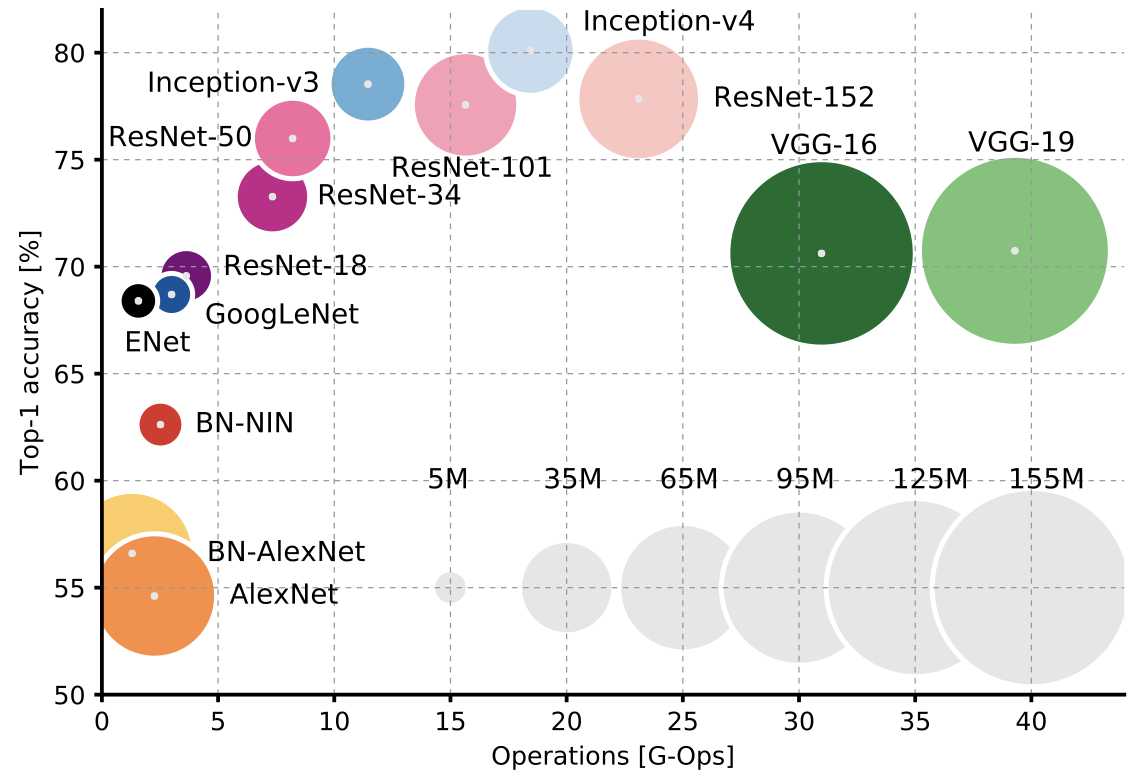
<br/>
<br/>
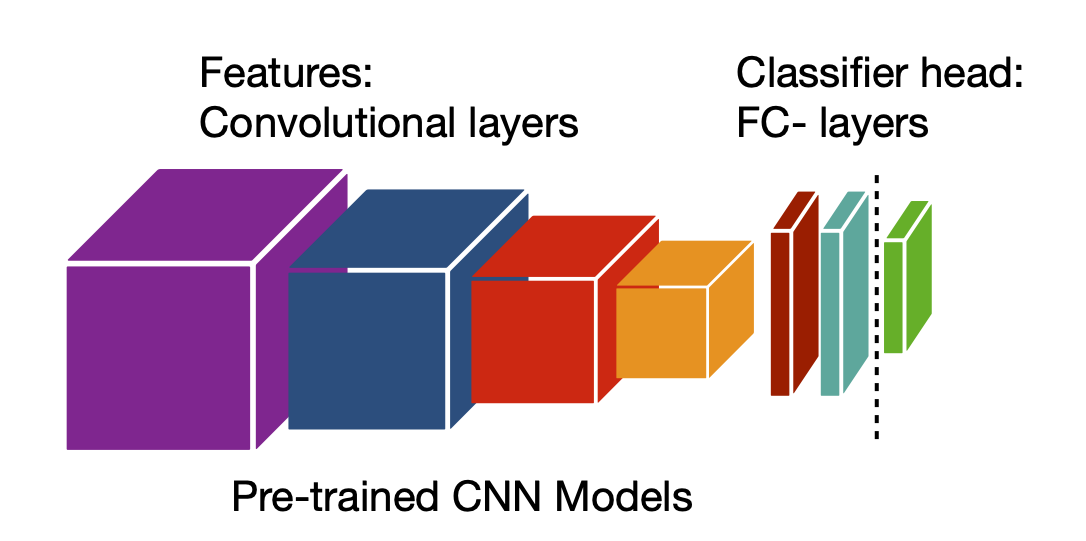
<br/><br/>
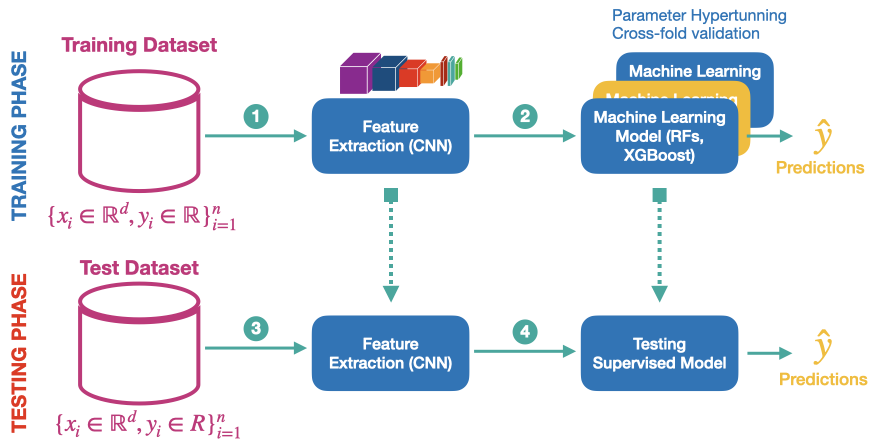

## GPU

In [31]:
plt.ion() 

use_gpu = torch.cuda.is_available()
device = torch.device('cuda' if use_gpu else 'cpu')
if use_gpu:
    print("Using CUDA")
else:
    print("Using CPU")

Using CPU


# VGG-16 Working (but really overfitted)

In [32]:
# Define hyperparameters (change as you see fit)
learning_rate = 1e-2
weight_decay = 1e-5
batch_size = 32
num_epochs = 10

In [33]:
class MultiLabelDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.labels_frame = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = self.labels_frame.iloc[idx, 0]  # Assuming filename is in the first column
        image = Image.open(f'{self.img_dir}/{img_name}')
        labels = self.labels_frame.iloc[idx, 1:].values.astype(float)
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels)

In [34]:
# Transform data into Tensor that has range [0,1]
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [35]:
# paths
img_dir = '/content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels/images'
csv_file = df_classes

dataset = MultiLabelDataset(df_classes, img_dir=img_dir, transform=transform)

In [36]:
# Split
# Define the proportions
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Make sure the ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1

# Calculate the number of samples to include in each split
total = len(dataset)
train_size = int(train_ratio * total)
val_size = int(val_ratio * total)
test_size = total - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [37]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [38]:
# Use pre-trained VGG16
model = torchvision.models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
# Modify the last layer
num_features = model.classifier[6].in_features
num_classes = len(dataset.labels_frame.columns) - 1  # subtract one for index column
model.classifier[6] = torch.nn.Linear(num_features, num_classes)

In [40]:
# Define a loss function and an optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lists for plotting
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    # Training
    model.train()  # set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()  # set the model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_loss_list.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/10, Train Loss: 0.6388, Validation Loss: 0.5295
Epoch 2/10, Train Loss: 0.4770, Validation Loss: 0.4243
Epoch 3/10, Train Loss: 0.4042, Validation Loss: 0.4201
Epoch 4/10, Train Loss: 0.3694, Validation Loss: 0.3303
Epoch 5/10, Train Loss: 0.3333, Validation Loss: 0.3070
Epoch 6/10, Train Loss: 0.2946, Validation Loss: 0.3051


In [ ]:
# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.sigmoid(outputs) > 0.5
        total += labels.size(0)
        correct += accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy(), normalize=False)

    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# unsuccessful tries (archive)

## 1

In [ ]:
print(image_dir)

In [ ]:
# classes imported before
image_dir = '/content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels/images/'

# Get the list of image filenames
image_filenames = os.listdir(image_dir)

# Filter the dataframe to include only the existing image filenames
df_classes_filtered = df_classes[df_classes['filename'].isin(image_filenames)]

# Split the data into train, validation, and test sets
train_df, test_df = train_test_split(df_classes_filtered, test_size=0.3, random_state=1)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1)

In [ ]:
import random

# Set the number of images to display
num_images = 5

# Randomly select image indices from the training set
random_indices_train = random.sample(range(len(train_df)), num_images)
random_indices_test = random.sample(range(len(test_df)), num_images)

# Display the randomly selected images with their labels
fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
for i, index in enumerate(random_indices_train):
    filename = train_df.iloc[index]['filename']
    image_path = image_dir + filename
    image = plt.imread(image_path)
    labels = train_df.iloc[index, 1:].values.astype(int)
    axes[i].imshow(image)
    axes[i].axis('off')
    label_names = [class_names[j] for j, label in enumerate(labels) if label == 1]
    axes[i].set_title(f'Train labels:\n {", ".join(label_names)}', fontsize=8)
    print(filename)
plt.show()

# Display the randomly selected images with their labels
fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
for i, index in enumerate(random_indices_test):
    filename = test_df.iloc[index]['filename']
    image_path = image_dir + filename
    image = plt.imread(image_path)
    labels = test_df.iloc[index, 1:].values.astype(int)
    axes[i].imshow(image)
    axes[i].axis('off')
    label_names = [class_names[j] for j, label in enumerate(labels) if label == 1]
    axes[i].set_title(f'Test labels:\n {", ".join(label_names)}', fontsize=8)
    print(filename)
plt.show()

In [ ]:
# Calculate the class distribution
class_counts = df_classes.iloc[:, 1:].sum().sort_values(ascending=False)

# Calculate the count of images with no class
no_class_count = len(df_classes) - df_classes.iloc[:, 1:].sum().sum()

# Add a separate category for images without a class
class_counts['No Class'] = no_class_count

# Plot the class distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and standard deviation
])

In [ ]:
# Define a custom dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        filename = self.dataframe.iloc[idx]['filename']
        image_path = f'{self.image_dir}/{filename}'
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        labels = self.dataframe.iloc[idx, 1:].values.astype(int)
        
        return image, labels

In [ ]:
# Create instances of the custom dataset for train, validation, and test sets
train_dataset = ImageDataset(train_df, image_dir, transform)
val_dataset = ImageDataset(val_df, image_dir, transform)
test_dataset = ImageDataset(test_df, image_dir, transform)

# Define the batch size and number of epochs
batch_size = 16
num_epochs = 10

# Create dataloaders for train, validation, and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the ResNet-101 model
class ResNet101(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101, self).__init__()
        self.resnet = models.resnet101(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
# Set the number of classes
num_classes = len(df_classes.columns) - 1
print(num_classes)

# Create an instance of the ResNet-101 model
model = ResNet101(num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from torchsummary import summary
summary(model.model, input_size=(3, 224, 224))

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.round(torch.sigmoid(outputs)).max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # Calculate training accuracy and loss
    train_accuracy = 100.0 * train_correct / train_total
    train_loss /= len(train_dataloader)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels.float())

            val_loss += loss.item()
            _, predicted = torch.round(torch.sigmoid(outputs)).max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = 100.0 * val_correct / val_total
    val_loss /= len(val_dataloader)

    # Print epoch-wise training statistics
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.2f}%")


## 2

In [ ]:
# Step 1: Data Preparation
class MultiLabelDataset(Dataset):
    def __init__(self, csv, root, transform=None):
        self.data = pd.read_csv(csv)
        self.root = root
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = torch.tensor(self.data.iloc[idx, 1:], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, labels

In [ ]:
# Step 2: Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

dataset = MultiLabelDataset(csv = "_classes.csv", root = "images", transform=transform)

In [ ]:
# Step 3: Splitting the Dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Step 4: Model Creation
resnet = models.resnet101(pretrained=True)
num_classes = 5  # Number of classes (labels)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)

In [ ]:
# Step 5: Model Compilation
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss for multi-label classification
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

In [ ]:
# Step 6: Model Training
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = resnet.to(device)

In [ ]:
# Step 6: Training Loop
epochs = 10

train_costs = []
val_costs = []
train_accs = []
val_accs = []

best_val_accuracy = 0.0  # Variable to store the best validation accuracy

for epoch in range(1, epochs + 1):
    # Training
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    resnet.train()  # Set the model to training mode
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.argmax(dim=1)).sum().item()
    
    # Calculate training accuracy and cost
    train_accuracy = (correct_train / total_train) * 100
    train_cost = train_loss / len(train_loader)
    
    # Validation
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    resnet.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels.argmax(dim=1)).sum().item()
    
    # Calculate validation accuracy and cost
    val_accuracy = (correct_val / total_val) * 100
    val_cost = val_loss / len(val_loader)
    
    # Print epoch-wise results
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Cost: {train_cost:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Cost: {val_cost:.4f} | Val Accuracy: {val_accuracy:.2f}%")
    print("=" * 50)
    
    # Save epoch-wise results
    train_costs.append(train_cost)
    val_costs.append(val_cost)
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
    
      # Save the model with the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(resnet.state_dict(), 'best_model.pth')

In [ ]:
# Step 7: Model Evaluation
resnet.eval()

In [ ]:
test_predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = resnet(images)
        predictions = torch.sigmoid(outputs) > 0.5
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_predictions = torch.tensor(test_predictions, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)


In [ ]:
# Calculate evaluation metrics
accuracy = (test_predictions == test_labels).float().mean()
precision = (test_predictions.bool() & test_labels.bool()).sum().float() / test_predictions.sum().float()
recall = (test_predictions.bool() & test_labels.bool()).sum().float() / test_labels.sum().float()
f1_score = 2 * precision * recall / (precision + recall)

print(f'Test Accuracy: {accuracy.item():.4f}')
print(f'Test Precision: {precision.item():.4f}')
print(f'Test Recall: {recall.item():.4f}')
print(f'Test F1 Score: {f1_score.item():.4f}')

In [ ]:
import random
import matplotlib.pyplot as plt

# Step 8: Model Prediction
resnet.eval()

test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        
        outputs = resnet(images)
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        test_predictions.extend(predictions.cpu().numpy())

test_predictions = torch.tensor(test_predictions, dtype=torch.float32)

# Print the predicted labels for test data
print("Predicted Labels for Test Data:")
for i, (prediction, (image, labels)) in enumerate(zip(test_predictions, test_dataset)):
    # Convert image tensor to NumPy array
    image_np = image.permute(1, 2, 0).cpu().numpy()
    
    # Display the image
    fig, ax = plt.subplots()
    ax.imshow(image_np)
    ax.axis('off')
    plt.show()
    
    # Print the image tensor labels
    print(f"Image {i+1} Labels: {labels}")
    
    # Print the predicted labels
    print(f"Predicted Labels: {prediction}\n")


## 3

In [ ]:
df_classes.head()

In [ ]:
# Extract image paths and labels
image_paths = df_classes.iloc[:, 0].tolist()
labels = df_classes.iloc[:, 1:6].values.tolist()

In [ ]:
print(labels)

In [ ]:
root_path = "/content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels/images"

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = root_path + "/" + self.image_paths[index]
        label = self.labels[index]

        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        # Check if cell or multi-cell label is present
        if label[0] == 1 or label[1] == 1:
            target = torch.tensor(0)  # Defected
        else:
            target = torch.tensor(1)  # Not Defected

        return image, target

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset(image_paths=image_paths, labels=labels, transform=transform)


In [ ]:
print(image_path)

In [ ]:
print(labels)

In [ ]:
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(dataset))
valid_size = int(valid_ratio * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size], generator=torch.Generator().manual_seed(42))


In [ ]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)


In [ ]:
# criterion = nn.CrossEntropyLoss()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
import matplotlib.pyplot as plt

# Training loop
num_epochs = 10
best_valid_loss = float('inf')

train_losses = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    valid_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        valid_loss /= len(valid_loader.dataset)
        accuracy = correct / len(valid_loader.dataset)

        valid_losses.append(valid_loss)
        valid_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {train_loss:.4f}, '
              f'Valid Loss: {valid_loss:.4f}, '
              f'Valid Accuracy: {accuracy:.4f}')

        # Save the model if the validation loss is the best so far
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pt')

# Plotting the loss and accuracy graphs
epochs = range(1, num_epochs+1)

plt.figure()
plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
plt.plot(epochs, valid_losses, 'r-o', label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, valid_accuracies, 'g-o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
test_loss = 0.0
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

In [ ]:
predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

label_mapping = {0: 'Defected', 1: 'Not Defected'}

for i, prediction in enumerate(predictions):
    image_path = test_dataset.dataset.image_paths[i][0]
    label = label_mapping[prediction]
    print(f'{image_path} - Predicted Label: {label}')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

predictions = []
images_to_plot = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

        # Collect the images for plotting
        images_to_plot.extend(images.cpu().numpy())

label_mapping = {0: 'Defected', 1: 'Not Defected'}

for image, prediction in zip(images_to_plot, predictions):
    # Reshape and normalize the image
    image = np.transpose(image, (1, 2, 0))
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # Plot the image
    plt.imshow(image)
    plt.title(f'Predicted Label: {label_mapping[prediction]}')
    plt.axis('off')
    plt.show()